In [1]:
# This notebook is trying out different pipeline approaches

# Cropped data is used here (5 minutes only), tried on whole data - takes forever.


#Load data, make folders
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import mne
import pyprep as pp

In [2]:
#from Functions.main_meg_qc import initial_stuff
from data_load_and_folders import load_meg_data
duration=5 #in minutes
#n_events, df_epochs_mags, df_epochs_grads, epochs_mags, epochs_grads, mags, grads, filtered_d, filtered_d_resamp, raw_cropped, raw=initial_stuff(duration)

#data_file = '/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003483/sub-009/ses-1/meg/sub-009_ses-1_task-deduction_run-1_meg.fif'
#data_file = '/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003352/sub-1/ses-01/meg/sub-1_ses-01_task-ColorSpirals_run-00_meg.fif'
#data_file = '/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003352/sub-4/ses-02/meg/sub-4_ses-02_task-ColorSpirals_run-01_meg.fif'
#data_file = '/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003392/sub-01/meg/sub-01_task-localizer_meg.fif'
#data_file = '/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003645/sub-002/meg/sub-002_task-FacePerception_run-1_meg.fif'
data_file = '/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003682/sub-001/ses-01/meg/sub-001_ses-01_task-AversiveLearningReplay_run-01_meg.fif'


raw, channels = load_meg_data(data_file)

#crop the data to calculate faster
raw_cropped = raw.copy()
#raw_cropped.crop(tmin=1100, tmax=None) 

raw_cropped

Opening raw data file /Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003682/sub-001/ses-01/meg/sub-001_ses-01_task-AversiveLearningReplay_run-01_meg.fif...
    Read 5 compensation matrices
    Range : 0 ... 389231 =      0.000 ...   324.359 secs
Ready.
Current compensation grade : 3


<Raw | sub-001_ses-01_task-AversiveLearningReplay_run-01_meg.fif, 414 x 389232 (324.4 s), ~649 kB, data not loaded>

    Coordinate transformations established.
    t=0.000:     3/3 good HPI fits, movements [mm/s] =      1.8 /      5.5 /      0.8
    t=0.040:     3/3 good HPI fits, movements [mm/s] =      0.8 /      2.9 /      0.3
    t=0.120:     3/3 good HPI fits, movements [mm/s] =      0.4 /      0.8 /      0.4
    t=0.200:     3/3 good HPI fits, movements [mm/s] =      0.8 /      0.3 /      0.3
    t=0.240:     3/3 good HPI fits, movements [mm/s] =      1.3 /      1.2 /      1.4
    t=0.280:     3/3 good HPI fits, movements [mm/s] =      1.4 /      1.8 /      0.2
    t=0.360:     3/3 good HPI fits, movements [mm/s] =      0.4 /      0.8 /      0.2
    t=0.400:     3/3 good HPI fits, movements [mm/s] =      1.5 /      2.4 /      0.6
    t=0.440:     3/3 good HPI fits, movements [mm/s] =      0.5 /      2.5 /      1.0
    t=0.480:     3/3 good HPI fits, movements [mm/s] =      0.6 /      2.1 /      0.7
    t=0.520:     3/3 good HPI fits, movements [mm/s] =      0.4 /      1.9 /      0.6
    t=0.56

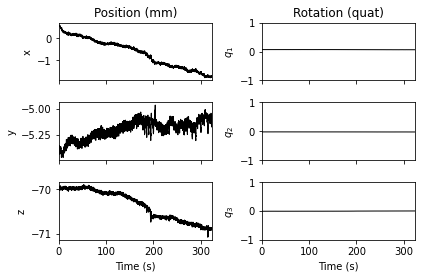

Omitting  53.4% ( 36 segments): disp >= 0.0015m (max: 0.0032m)
Using qt as 2D backend.
Opening raw-browser...
Using pyopengl with version 3.1.1a1


2022-11-08 09:54:23,359 - OpenGL.acceleratesupport - INFO - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


In [3]:
# Annotate movement - like in tutorial 2 from:
# https://mne.tools/stable/generated/mne.preprocessing.annotate_movement.html

from mne.preprocessing import annotate_movement, compute_average_dev_head_t

# Get cHPI time series and compute average
chpi_locs = mne.chpi.extract_chpi_locs_ctf(raw)
head_pos = mne.chpi.compute_head_pos(raw.info, chpi_locs)
original_head_dev_t = mne.transforms.invert_transform(
    raw.info['dev_head_t'])
average_head_dev_t = mne.transforms.invert_transform(
    compute_average_dev_head_t(raw, head_pos))
fig = mne.viz.plot_head_positions(head_pos)
for ax, val, val_ori in zip(fig.axes[::2], average_head_dev_t['trans'][:3, 3],
                            original_head_dev_t['trans'][:3, 3]):
    ax.axhline(1000 * val, color='r')
    ax.axhline(1000 * val_ori, color='g')

# The green horizontal lines represent the original head position, whereas the
# red lines are the new head position averaged over all the time points.

mean_distance_limit = 0.0015  # in meters
annotation_movement, hpi_disp = annotate_movement(
    raw, head_pos, mean_distance_limit=mean_distance_limit)
raw.set_annotations(annotation_movement)
raw.plot(n_channels=100, duration=20)

In [4]:
# try another tutorial: 
# (takes some minutes depends how big is raw_cropped: 2-40 min):
# https://mne.tools/stable/auto_tutorials/preprocessing/59_head_positions.html#sphx-glr-auto-tutorials-preprocessing-59-head-positions-py

# cHPI - continuous head position indicator (HPI) coil channels, data in teslas

# 'We can use mne.chpi.get_chpi_info to retrieve the coil frequencies, the index of 
# the channel indicating when which coil was switched on, and the respective “event codes” 
# associated with each coil’s activity.'
chpi_freqs, ch_idx, chpi_codes = mne.chpi.get_chpi_info(info=raw_cropped.info, on_missing='warn', verbose=None)
# Output:
# - The frequency used for each individual cHPI coil.
# - The index of the STIM channel containing information about when which cHPI coils were switched on.
# - The values coding for the “on” state of each individual cHPI coil.

# The values coding for the “on” state of each individual cHPI coil.
print(f'cHPI coil frequencies extracted from raw: {chpi_freqs} Hz')

#We only got 5, not 9 HPI (see error in cell above)


#extract the HPI coil amplitudes as a function of time:
print('Extract the HPI coil amplitudes as a function of time:')
chpi_amplitudes=mne.chpi.compute_chpi_amplitudes(raw_cropped)
#chpi_amplitudes=mne.chpi.compute_chpi_amplitudes(raw_cropped, t_step_min=0.01, t_window='auto', ext_order=1, tmin=0, tmax=None, verbose=None)


#compute time-varying HPI coil locations from these
print('Compute time-varying HPI coil locations from these')
#chpi_locs=mne.chpi.compute_chpi_locs(raw_cropped.info, chpi_amplitudes, t_step_max=1.0, too_close='raise', adjust_dig=False, verbose=None)
chpi_locs=mne.chpi.compute_chpi_locs(raw_cropped.info, chpi_amplitudes)


print('Compute head positions from the coil locations:')
#compute head positions from the coil locations:
head_pos = mne.chpi.compute_head_pos(raw_cropped.info, chpi_locs, verbose=True)
print('head_positions computed:', head_pos)

/var/folders/h2/khhmb4p510vg63hbv0qkftt80000gs/T/ipykernel_50485/370082608.py:10: RuntimeWarning: No appropriate cHPI information found in info["hpi_meas"] and info["hpi_subsystem"]
  chpi_freqs, ch_idx, chpi_codes = mne.chpi.get_chpi_info(info=raw_cropped.info, on_missing='warn', verbose=None)


cHPI coil frequencies extracted from raw: [] Hz
Extract the HPI coil amplitudes as a function of time:


ValueError: No appropriate cHPI information found in info["hpi_meas"] and info["hpi_subsystem"]

In [ ]:
#Visualizing continuous head position: doesnt work

mne.viz.plot_head_positions(head_pos, mode='traces')
#mne.viz.plot_head_positions(head_pos, mode='field')

In [ ]:
# Now again try to annotate movement: also error - It didnt calculate any positions!

mean_distance_limit = 0.0015  # in meters
annotation_movement, hpi_disp = annotate_movement(
    raw_cropped, head_pos, mean_distance_limit=mean_distance_limit)
raw_cropped.set_annotations(raw_cropped.annotations + annotation_movement)
raw_cropped.plot(n_channels=100, duration=20)